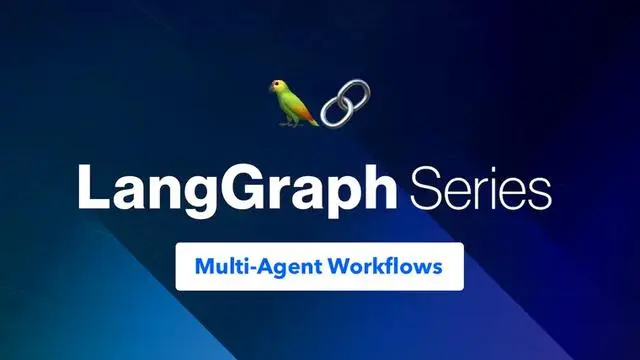


LangGraph 是一个有用于构建有状态和多角色的 Agents 应用，它并不是一个独立于 Langchain 的新框架，而是基于 Langchain 之上构建的一个扩展库，可以与 Langchain 现有的链（Chains）、LangChain Expression Language（LCEL）等无缝协作。LangGraph 能够协调多个 Chain、Agent、Tool 等共同协作来完成输入任务，支持 LLM 调用“循环”和 Agent 过程的更精细化控制。

LangGraph 的实现方式是把之前基于 AgentExecutor 的黑盒调用过程，用一种新的形式来构建：状态图（StateGraph）。把基于 LLM 的任务（比如：RAG、代码生成等）细节用 Graph 进行精确的定义（定义图的节点与边），最后基于这个图来编译生成应用。在任务运行过程中，维持一个中央状态对象(state)，会根据节点的跳转不断更新，状态包含的属性可自行定义

LangGraph发布，多代理工作流框架助力应用开发者在应用层搭建自己的多专家模型。LangGraph提供Python和JS版本，支持包含循环的LLM工作流创建。多代理工作流通过独立代理节点和连接表示，有助于开发概念模型。GPT-Newspaper和CrewAI两个基于LangGraph构建的第三方应用程序示例。

## LangGraph 的几个基本概念：

StateGraph：代表整个状态图的基础类。

Nodes：节点。有了图之后，可以向图中添加节点，节点通常是一个可调用的函数、一个可运行的 Chain 或 Agent。有一个特殊的节点叫END，进入这个节点，代表运行结束。

在上图中，推理函数调用、调用检索器、生成响应内容、问题重写等都是其中的任务节点。

Edges：边。有了节点后，需要向图中添加边，边代表从上一个节点跳转到下一个节点的关系。目前有三种类型的边：

Starting Edge、一种特殊的边。用来定义任务运行的开始节点，它没有上一个节点。

Normal Edge：普通边。代表上一个节点运行完成后立即进入下一个节点。比如在调用 Tools 后获得结果后，立刻进入 LLM 推理节点。

Conditional Edge：条件边。代表上一个节点运行完成后，需要根据条件跳转到某个节点，因此这种边不仅需要上游节点、下游节点，还需要一个条件函数，根据条件函数的返回来决定下游节点。

在上图中，Check Relevance 就是一个条件边，它的上游节点是检索相关文档，条件函数是判断文档是否相关，如果相关，则进入下游节点【产生回答】；如果不相关，则进入下游节点【重写输入问题】。

In [1]:
from langchain_openai import ChatOpenAI, OpenAI

openai_api_key = "EMPTY"
openai_api_base = "http://127.0.0.1:1234/v1"
llm = ChatOpenAI(
    openai_api_key=openai_api_key,
    openai_api_base=openai_api_base,
    temperature=0.3,
)

In [18]:
import requests
import json
from langchain.agents import tool
# SearXNG 的实例 URL，你可以使用官方实例或自托管实例
@tool
def searxng_search(query):
    """输入搜索内容，使用 SearXNG 进行搜索。"""
    SEARXNG_URL = 'http://127.0.0.1:6688/search'
    params = {}
    # 设置搜索参数
    params['q'] = query
    params['format'] = 'json'  # 返回 JSON 格式的结果
    params['engines'] = 'bing'
    # 发送 GET 请求
    response = requests.get(SEARXNG_URL,params)
    #return response.text
    # 检查响应状态码
    if response.status_code == 200:
        res = response.json()
        # print(res)
        resList = []
        for item in res['results']:
            resList.append({
                "title":item['title'],
                "content":item['content'],
                "url":item['url']
            })
            if len(resList) >= 3:
                break
        return resList 
    else:
        response.raise_for_status()
        
searxng_search.invoke("郭德纲")

[{'title': '郭德纲_百度百科',
  'content': '郭德纲，1973年1月18日出生于中国天津市，祖籍中国山西省，中国内地相声演员、导演、编剧、歌手、演员、主持人、北京德云社创始人。. 1979年，开始学艺。. 1989年，到红桥文化馆工作。. 1998年，创办北京相声大会（德云社前身）。. 2000年，开始与于谦合作 ...',
  'url': 'https://baike.baidu.com/item/%E9%83%AD%E5%BE%B7%E7%BA%B2/175780'},
 {'title': '郭德纲21年相声精选免费在线收听-喜马拉雅',
  'content': '郭德纲21年相声精选 强势来袭！ 老郭经典相声，入坑必备！ 每一集都有你意料之外的包袱. 每一场都是德云粉丝的必修课. 每一句都是老郭的经典爆笑演绎. 每一秒都是你不容错过的快乐时光. 本专辑为喜马拉雅【音频独家】节目. 【德云更多精彩专辑，点击直达】 更多全部. 声音 （144） 评价 （1w+） 正序 | 倒序. 1. 《败家子儿》 郭德纲 于谦. 9844.7万. 2017-08. …',
  'url': 'https://www.ximalaya.com/xiangsheng/9723091/'},
 {'title': '郭德纲-哔哩哔哩_Bilibili',
  'content': '郭德纲 经典相声合集. 黑夜星宿 · 2019-1-4. 3020.3万 6.8万. 60:27:36. 郭德纲 和于谦合说的相声. 夏后氏姒文命 · 2019-1-31. 6.4万 3. 01:26:24. 郭德纲 于谦 相声《买豆汁》 高音质 安睡版. 今晚睡这 · 昨天. 66.3万 1286. 01:28:33. 【2024年元宵节专场全程回顾】“终于上新段子了！ ”《富贵人生》+《四大传说》+《负荆请罪》 郭德纲 于 …',
  'url': 'https://www.bilibili.com/v/channel/8892/'}]

In [25]:
promptTemplate = """尽可能的帮助用户回答任何问题。

您可以使用以下工具来帮忙解决问题，如果已经知道了答案，也可以直接回答：

searxng_search : searxng_search(query) -> 输入搜索内容，使用 SearXNG 进行搜索。

回复格式说明
----------------------------

回复我时，请以以下两种格式之一输出回复：

选项 1：如果您希望人类使用工具，请使用此选项。
采用以下JSON模式格式化的回复内容,回复的格式里不要有注释内容：

```json
{{
    "reason": string, \\ 叙述使用工具的原因
    "action": "searxng_search", \\ 要使用的工具。 必须是 searxng_search
    "action_input": string \\ 工具的输入
}}
````

选项2：如果您认为你已经有答案或者已经通过使用工具找到了答案，想直接对人类做出反应，请使用此选项。 采用以下JSON模式格式化的回复内容,回复的格式里不要有注释内容：

```json
{{
  "action": "Final Answer",
  "answer": string \\最终答复问题的答案放到这里！
}}
````

用户的输入
--------------------
这是用户的输入（请记住通过单个选项，以JSON模式格式化的回复内容,回复的格式里不要有注释内容，不要回复其他内容）：

{input}

"""

In [26]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "你是非常强大的助手，你可以使用各种工具来完成人类交给的问题和任务。",
        ),
        ("user", promptTemplate),
    ]
)

In [27]:
from langchain.agents.agent import AgentOutputParser
from langchain_core.output_parsers.json import parse_json_markdown
from langchain_core.exceptions import OutputParserException
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.output_parsers import StrOutputParser
class JSONAgentOutputParser(AgentOutputParser):

    def parse(self, text):
        try:
            response = parse_json_markdown(text)
            if isinstance(response, list):
                # 经常忽略发出单个动作的指令
                logger.warning("Got multiple action responses: %s", response)
                response = response[0]
            if response["action"] == "Final Answer":
                return AgentFinish({"output": response["answer"]}, text)
            else:
                return AgentAction(
                    response["action"], response.get("action_input", {}), text
                )
        except Exception as e:
            raise OutputParserException(f"Could not parse LLM output: {text}") from e

    @property
    def _type(self) -> str:
        return "json-agent"

In [75]:
output_parser = StrOutputParser()
chain1 = prompt | llm 

chain1.invoke({"input":"小米su7的发布时间"})

AIMessage(content='{\n  "action": "searxng_search",\n  "reason": "查询小米su7的发布时间",\n  "action_input": "小米su7 发布时间"\n}', response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 46, 'total_tokens': 92}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None})

In [76]:
chain1.invoke({"input":"请使用中文给我讲个笑话吧？"})

AIMessage(content='{\n  "action": "Final Answer",\n  "answer": "为什么中国人都喜欢用筷子呢？因为西方人发明了刀叉。"\n}', response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 36, 'total_tokens': 72}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None})

In [77]:
promptTemplate = """使用浏览器获取的搜索内容：
---------------------
{observation}
---------------------
请根据浏览器的响应，回答下面的问题：

{input}"""

prompt2 = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "你是非常强大的助手，你可以使用各种工具来完成人类交给的问题和任务。",
        ),
        ("user", promptTemplate),
    ]
)


In [ ]:
chain2 =   prompt2 | llm 

In [79]:
result = searxng_search.invoke("小米su7 发布时间")
result

[{'title': '不负三年之约：小米汽车 SU7 官宣 3 月 28 日正式上市，上市 ...',
  'content': '小米汽车发布会官宣定档 3 月 28 日，全国 29 城，59 家门店同步开启小米 SU7 预约。 作为小米汽车首款产品，小米 SU7 定位轿跑车型，该车拥有运动化的外观和科技感十足的内饰，单电机版 299 马力，双电机版 673 马力，续航可达 668-800km。',
  'url': 'https://www.ithome.com/0/755/070.htm'},
 {'title': '小米汽车宣布发布会时刻：3月28日晚7点见！ - 知乎专栏',
  'content': '小米汽车官宣小米SU7上市发布会精确时间，3月28日晚上7点。并称小米SU7准备好了，人车家全生态准备好了，小米汽车工厂准备好了，上市即交付，交付即商量。 从小米汽车官方信息来看，小米汽车是做好了一切…',
  'url': 'https://zhuanlan.zhihu.com/p/688867140'},
 {'title': '雷军宣布「小米 SU7 将于 3 月 28 日正式发布」，哪些信息 ...',
  'content': '发布微博称， “3月28日，小米SU7正式发布，这是我们的三年之约。 ”小米汽车官方微博称，上市即交付，交付即上量。 [图片] [图片]… 显示全部 . 关注者. 16. 被浏览. 7,892. 关注问题. 写回答. 邀请回答. 好问题. 添加评论. 分享. 12 个回答. 默认排序. 刘长江长. 心里总有个梦想，像英雄一样的走过这世 …',
  'url': 'https://www.zhihu.com/question/648170850'}]

In [80]:
chain2.invoke({"input":"小米su7的发布时间","observation":result})

AIMessage(content='小米 SU7 的发布时间是 3 月 28 日。', response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 14, 'total_tokens': 28}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None})

In [81]:
from langgraph.graph import END, MessageGraph

graph = MessageGraph()

graph.add_node("chain", chain1)
graph.add_edge("chain", END)

graph.set_entry_point("chain")

runnable1 = graph.compile()

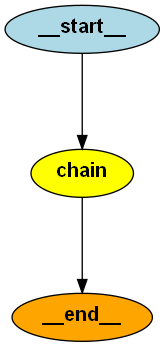

In [82]:
from IPython.display import Image

Image(runnable1.get_graph().draw_png())

In [84]:
# promptValue = prompt.invoke({"input":"小米su7的发布时间"})
from langchain_core.messages import HumanMessage
runnable1.invoke(HumanMessage("小米su7的发布时间"))

[HumanMessage(content='小米su7的发布时间', id='91444156-03ad-4be9-988c-10788ddb56c3'),
 AIMessage(content='{\n  "action": "searxng_search",\n  "reason": "查询小米su7的发布时间，需要使用搜索引擎获取相关信息。",\n  "action_input": "小米su7 发布时间"\n}', response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 54, 'total_tokens': 108}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='3d65483c-7fe2-4152-b333-bac3a723ec13')]

In [98]:
def process(state):
    print(state)
    content = state[-1].content
    return {"input":state[0].content,"observation":content}

chain2 =  process | prompt2 | llm 

In [99]:
from langgraph.graph import END, MessageGraph

graph = MessageGraph()

def tool(state):
    print(state)
    content = state[-1].content
    response = parse_json_markdown(content)

    result = searxng_search.invoke(response["action_input"])
    return HumanMessage(result)

graph.add_node("chain1", chain1)
graph.add_node("tool",tool)
graph.add_node("chain2", chain2)




# 设置开始
graph.set_entry_point("chain1")

# 设置条件边
def router(state):
    print(state)
    content = state[-1].content
    response = parse_json_markdown(content)
    if response["action"] == "Final Answer":
        return "end"
    else:
        return "tool"
graph.add_conditional_edges("chain1", router, {
    "tool": "tool",
    "end": END,
})

graph.add_edge("tool", "chain2")
graph.add_edge("chain2", END)




runnable2 = graph.compile()

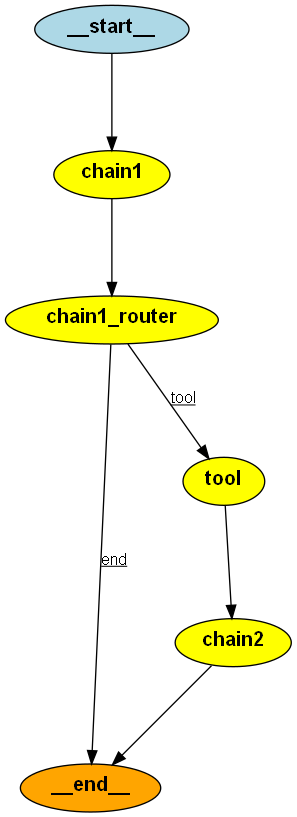

In [100]:
from IPython.display import Image

Image(runnable2.get_graph().draw_png())

In [101]:
runnable2.invoke(HumanMessage("小米su7的发布时间"))

[HumanMessage(content='小米su7的发布时间', id='93975606-8668-4993-b204-a03a11807f13'), AIMessage(content='{\n  "action": "searxng_search",\n  "reason": "查询小米su7的发布时间，需要搜索相关资讯。",\n  "action_input": "小米su7 发布时间"\n}', response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 52, 'total_tokens': 104}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='3b821b2a-4dd8-4b04-9690-669f586679a7')]
[HumanMessage(content='小米su7的发布时间', id='93975606-8668-4993-b204-a03a11807f13'), AIMessage(content='{\n  "action": "searxng_search",\n  "reason": "查询小米su7的发布时间，需要搜索相关资讯。",\n  "action_input": "小米su7 发布时间"\n}', response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 52, 'total_tokens': 104}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='3b821b2a-4dd8-4b04-9690-669f586679a7')]
[HumanMessage(content='小米su7的发布时间', id='93975606-8668-4993-b204-a03a11807f13'), AIMe

[HumanMessage(content='小米su7的发布时间', id='93975606-8668-4993-b204-a03a11807f13'),
 AIMessage(content='{\n  "action": "searxng_search",\n  "reason": "查询小米su7的发布时间，需要搜索相关资讯。",\n  "action_input": "小米su7 发布时间"\n}', response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 52, 'total_tokens': 104}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='3b821b2a-4dd8-4b04-9690-669f586679a7'),
 HumanMessage(content=[{'title': '不负三年之约：小米汽车 SU7 官宣 3 月 28 日正式上市，上市 ...', 'content': '小米汽车发布会官宣定档 3 月 28 日，全国 29 城，59 家门店同步开启小米 SU7 预约。 作为小米汽车首款产品，小米 SU7 定位轿跑车型，该车拥有运动化的外观和科技感十足的内饰，单电机版 299 马力，双电机版 673 马力，续航可达 668-800km。', 'url': 'https://www.ithome.com/0/755/070.htm'}, {'title': '小米汽车宣布发布会时刻：3月28日晚7点见！ - 知乎专栏', 'content': '小米汽车官宣小米SU7上市发布会精确时间，3月28日晚上7点。并称小米SU7准备好了，人车家全生态准备好了，小米汽车工厂准备好了，上市即交付，交付即商量。 从小米汽车官方信息来看，小米汽车是做好了一切…', 'url': 'https://zhuanlan.zhihu.com/p/688867140'}, {'title': '雷军宣布「小米 SU7 将于 3 月 28 日正式发布」，哪些信息 ...', 'content'